In [1]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import ast

def load(file):
    df = pd.read_csv(file)
    
    # convert the column values from literal string to dictionary
    df['ltiFeatures'] = df['ltiFeatures'].apply(ast.literal_eval)
    df['stiFeatures'] = df['stiFeatures'].apply(ast.literal_eval)

    return df

# load all the data
training = load("training.csv")
validation = load("validation.csv")
interest_topics = pd.read_csv("interest_topics.csv")

data_train = pd.DataFrame(list(training['ltiFeatures']))
data_train.head()
y_train = training['inAudience']

data_train = np.nan_to_num(data_train)

y_train = np.nan_to_num(y_train)

y_train = y_train.astype(int)

Using TensorFlow backend.


In [2]:
for i in range(0,96406):
    if y_train[i] == 0:
        y_train[i] = -1

[ 1  1  1 ... -1 -1 -1]


In [3]:
 #used to help randomly select the data points
data_split = 0.2
seed = 1234

In [4]:
# take data corresponding to false
x_train_scaled = data_train[1465:,:]

In [6]:
pca = PCA(0.99)
pca.fit(x_train_scaled)
x_pca_train = pca.transform(x_train_scaled)

In [7]:
batch_size = 128
input_dim = x_pca_train.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(374, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(94, activation="relu")(encoder)
encoder = Dense(24, activation="relu")(encoder)
encoder = Dense(6, activation="relu")(encoder)
decoder = Dense(6, activation="relu")(encoder)
decoder = Dense(24, activation="relu")(decoder)
decoder = Dense(94, activation="relu")(decoder)
decoder = Dense(374, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 450)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 374)               168674    
_________________________________________________________________
dense_2 (Dense)              (None, 94)                35250     
_________________________________________________________________
dense_3 (Dense)              (None, 24)                2280      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 150       
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_6 (Dense)              (None, 24)                168 

In [8]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')


In [9]:
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=1)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(x_pca_train, x_pca_train,
                    epochs = 50,
                    batch_size=100,
                    shuffle=True,
                    validation_split = 0.2,
                    verbose=1,
                    callbacks=[cp, tb]).history

Train on 75952 samples, validate on 18989 samples
Epoch 1/50
75952/75952 [==============================] - 11s 146us/step - loss: 0.0034 - accuracy: 0.0558 - val_loss: 3.1854e-04 - val_accuracy: 0.0510

Epoch 00001: val_loss improved from inf to 0.00032, saving model to autoencoder_classifier.h5
Epoch 2/50
75952/75952 [==============================] - 11s 141us/step - loss: 2.4675e-04 - accuracy: 0.0554 - val_loss: 3.0765e-04 - val_accuracy: 0.0193

Epoch 00002: val_loss improved from 0.00032 to 0.00031, saving model to autoencoder_classifier.h5
Epoch 3/50
75952/75952 [==============================] - 11s 147us/step - loss: 2.4329e-04 - accuracy: 0.0577 - val_loss: 3.0721e-04 - val_accuracy: 0.1608

Epoch 00003: val_loss improved from 0.00031 to 0.00031, saving model to autoencoder_classifier.h5
Epoch 4/50
75952/75952 [==============================] - 12s 157us/step - loss: 2.4328e-04 - accuracy: 0.0472 - val_loss: 3.0716e-04 - val_accuracy: 0.0510

Epoch 00004: val_loss improved f

75952/75952 [==============================] - 11s 140us/step - loss: 2.4327e-04 - accuracy: 0.0518 - val_loss: 3.0722e-04 - val_accuracy: 0.0171

Epoch 00038: val_loss did not improve from 0.00031
Epoch 39/50
75952/75952 [==============================] - 11s 143us/step - loss: 2.4326e-04 - accuracy: 0.0575 - val_loss: 3.0736e-04 - val_accuracy: 0.0220

Epoch 00039: val_loss did not improve from 0.00031
Epoch 40/50
75952/75952 [==============================] - 11s 141us/step - loss: 2.4326e-04 - accuracy: 0.0458 - val_loss: 3.0723e-04 - val_accuracy: 0.1608

Epoch 00040: val_loss did not improve from 0.00031
Epoch 41/50
75952/75952 [==============================] - 11s 140us/step - loss: 2.4327e-04 - accuracy: 0.0515 - val_loss: 3.0733e-04 - val_accuracy: 0.0417

Epoch 00041: val_loss did not improve from 0.00031
Epoch 42/50
75952/75952 [==============================] - 11s 143us/step - loss: 2.4326e-04 - accuracy: 0.0503 - val_loss: 3.0729e-04 - val_accuracy: 0.0448

Epoch 00042: 

In [10]:
autoencoder = load_model('autoencoder_classifier.h5')


In [11]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [12]:
data_pca_train = pca.transform(data_train)
x_predictions = autoencoder.predict(data_pca_train)

In [13]:
mse = np.mean(np.power(data_pca_train - x_predictions, 2), axis=1)
print(np.shape(mse))

(96406,)


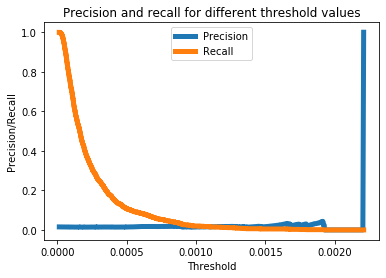

In [14]:
error = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_train})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error.True_class, error.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

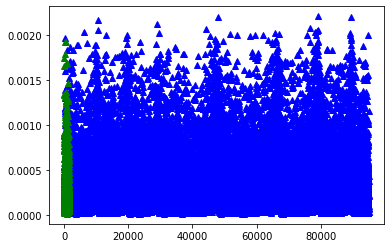

In [15]:
plt.plot(range(0,94941),mse[1465:],'b^')
plt.plot(range(0,1464),mse[0:1464],'g^')

In [16]:
data_test = pd.DataFrame(list(validation['ltiFeatures'])).drop(['1670'],axis = 1)
data_test.head()
y_test = validation['inAudience']


data_test = np.nan_to_num(data_test)

y_test = np.nan_to_num(y_test)

y_test = y_test.astype(int)

In [17]:

x_pca_test = pca.transform(data_test)

In [18]:
x__test_predictions = autoencoder.predict(x_pca_test)

In [19]:
mse_test = np.mean(np.power(x_pca_test - x__test_predictions, 2), axis=1)
print(mse_test)

[7.65590099e-05 1.57825355e-04 1.04490104e-04 ... 8.01297152e-05
 1.68941990e-04 1.36833550e-04]


In [20]:
y_test_labels = np.zeros((80008,1))
for i in range(0,80008):
    if mse_test[i] >= 0.0016:
        y_test_labels[i] = 1
        

In [21]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [22]:
print(perf_measure(y_test,y_test_labels))

(5, 142, 79246, 615)
